In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import json
import pickle
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, Input, concatenate
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.models import model_from_json, load_model, Model
from tensorflow.keras.optimizers import Adam
import plotly.express as px
import albumentations as A


2025-04-07 21:03:46.879294: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-07 21:03:46.966642: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-07 21:03:46.970434: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/taras/.pyenv/versions/3.10.12/envs/Artefact/lib/python3.10/site-packages/cv2/.

In [2]:
# 1️⃣ Load and Preprocess Data
# Constants to define
IMG_SIZE = (256, 256)
X_SIZE = IMG_SIZE[0]
Y_SIZE = IMG_SIZE[1]
TRAIN_DATASET_PATH = "../dataset/train/"
TRAIN_IMAGES_PATH = os.path.join(TRAIN_DATASET_PATH, "images")
TRAIN_MASKS_PATH = os.path.join(TRAIN_DATASET_PATH, "targets")  # Segmentation masks
TRAIN_LABELS_PATH = os.path.join(TRAIN_DATASET_PATH, "labels")  # JSON labels

TEST_DATASET_PATH = "../dataset/test/"
TEST_IMAGES_PATH = os.path.join(TEST_DATASET_PATH, "images")
TEST_MASKS_PATH = os.path.join(TEST_DATASET_PATH, "targets")  # Segmentation masks
TEST_LABELS_PATH = os.path.join(TEST_DATASET_PATH, "labels")  # JSON labels

BATCH_SIZE = 4  # Number of images to treat at once (Adjust depending on your RAM)
BUFFER_SIZE = 5000  # Total number of images to load from dataset

N_AUG = 0 # Number of augmented images to generate

In [3]:
# Function to load and preprocess images and masks
def load_image(image_path,verbose=0):
    """Load and preprocess images."""
    img = cv2.imread(image_path)

    if verbose==0:  # LOad messages
        pass
    elif verbose == 1:
        if img is None:
            print(f"❌ Failed to load image: {image_path}")
            return None
        print(f"✅ Loaded image {image_path}, Shape: {img.shape}, Dtype: {img.dtype}")

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, IMG_SIZE) / 255.0  # Normalize
    return img

def load_mask(mask_path,num_classes=5,verbose=0):
    """Load and preprocess masks."""
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    if verbose==0:  # LOad messages
        pass
    elif verbose == 1:
        if mask is None:
            print(f"❌ Failed to load mask: {mask_path}")
            return None
        print(f"✅ Loaded mask {mask_path}, Shape: {mask.shape}, Dtype: {mask.dtype}")

    mask = cv2.resize(mask, IMG_SIZE, interpolation=cv2.INTER_NEAREST)
    mask = tf.keras.utils.to_categorical(mask, num_classes=num_classes)
    mask.astype(np.float32)
    return mask


In [4]:
# # Find images with at least X unique pixel values
# def find_images_with_min_unique_values(folder_path, min_unique_values=3):
#     """Finds images in a folder with at least `min_unique_values` unique pixel values."""
    
#     image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
#     valid_images = []

#     for file in image_files:
#         print(f"Checking {file}...")
#         img_path = os.path.join(folder_path, file)
#         mask = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
        
#         if mask is None:
#             print(f"❌ Could not load {file}")
#             continue
        
#         unique_values = np.unique(mask)  # Get unique pixel values
        
#         if len(unique_values) >= min_unique_values:
#             valid_images.append(file)  # Store filenames that meet the condition

#     return valid_images

# # Example usage
# folder = "../dataset/train/targets"
# matching_images = find_images_with_min_unique_values(folder, min_unique_values=5)

# print("Images with at least 3 unique pixel values:")
# matching_images

In [5]:
# # Load and visualize a sample image and mask (mask is a 5-channel image with one-hot encoding)
# a = load_mask(TRAIN_MASKS_PATH+"/hurricane-michael_00000486_post_disaster_target.png")
# b = load_image(TRAIN_IMAGES_PATH+"/hurricane-michael_00000486_post_disaster.png")
# print(a.shape)
# plt.subplot(321)
# plt.title("Post Disaster Image")
# plt.imshow(b)
# plt.axis('off')
# plt.subplot(322)
# plt.title("Background pixels")
# plt.imshow(a[:,:,0])
# plt.axis('off')
# plt.subplot(323)
# plt.title("No damage")
# plt.imshow(a[:,:,1])
# plt.axis('off')
# plt.subplot(324)
# plt.title("Minor damage")
# plt.imshow(a[:,:,2])
# plt.axis('off')
# plt.subplot(325)
# plt.title("Major damage")
# plt.imshow(a[:,:,3])
# plt.axis('off')
# plt.subplot(326)
# plt.title("Destroyed")
# plt.imshow(a[:,:,4])
# plt.axis('off')



In [6]:
# Function to load dataset using tf.data
def dataset_generator(image_filenames, images_path, masks_path):
    """Generator function to yield images and masks."""
    for filename in image_filenames:
        pre_path = os.path.join(images_path, filename)
        post_path = os.path.join(images_path, filename.replace("_pre_disaster", "_post_disaster"))
        mask_path = os.path.join(masks_path, filename.replace("_pre_disaster.png", "_post_disaster_target.png"))

        pre_img = load_image(pre_path)
        post_img = load_image(post_path)
        mask_img = load_mask(mask_path) # Now returns (256, 256, 5)
        

        if pre_img is not None and post_img is not None and mask_img is not None:
            stacked_image = np.concatenate([pre_img, post_img], axis=-1)  # Shape: (256, 256, 6)
            yield stacked_image, mask_img

# Create TensorFlow dataset
def get_tf_dataset(image_filenames, images_path, masks_path, batch_size):
    # Create original dataset
    dataset = tf.data.Dataset.from_generator(
        lambda: dataset_generator(image_filenames, images_path, masks_path),
        output_signature=(
            tf.TensorSpec(shape=(X_SIZE, Y_SIZE, 6), dtype=tf.float32),
            tf.TensorSpec(shape=(X_SIZE, Y_SIZE, 5), dtype=tf.float32)  # One-hot encoded mask
        )
    )
    
    dataset = dataset.take(BUFFER_SIZE)  # Limit number of samples
    dataset = dataset.shuffle(BUFFER_SIZE)  # Shuffle the data
    dataset = dataset.batch(batch_size)  # Load in small batches
    dataset = dataset.prefetch(tf.data.AUTOTUNE)  # Optimize loading


    return dataset

In [7]:
# Function to load dataset using tf.data
def dataset_generator_aug(image_filenames, images_path, masks_path):
    """Generator function to yield images and masks."""
    for filename in image_filenames:
        pre_path = os.path.join(images_path, filename)
        post_path = os.path.join(images_path, filename.replace("_pre_disaster_aug", "_post_disaster_aug"))
        mask_path = os.path.join(masks_path, filename.replace("_pre_disaster_aug.png", "_post_disaster_target_aug.png"))

        pre_img = load_image(pre_path)
        post_img = load_image(post_path)
        mask_img = load_mask(mask_path) # Now returns (256, 256, 5)
        

        if pre_img is not None and post_img is not None and mask_img is not None:
            stacked_image = np.concatenate([pre_img, post_img], axis=-1)  # Shape: (256, 256, 6)
            yield stacked_image, mask_img

# Create TensorFlow dataset
def get_tf_dataset_aug(image_filenames, images_path, masks_path, batch_size):
    # Create original dataset
    dataset = tf.data.Dataset.from_generator(
        lambda: dataset_generator_aug(image_filenames, images_path, masks_path),
        output_signature=(
            tf.TensorSpec(shape=(X_SIZE, Y_SIZE, 6), dtype=tf.float32),
            tf.TensorSpec(shape=(X_SIZE, Y_SIZE, 5), dtype=tf.float32)  # One-hot encoded mask
        )
    )
    
    dataset = dataset.take(BUFFER_SIZE)  # Limit number of samples
    dataset = dataset.shuffle(BUFFER_SIZE)  # Shuffle the data
    dataset = dataset.batch(batch_size)  # Load in small batches
    dataset = dataset.prefetch(tf.data.AUTOTUNE)  # Optimize loading


    return dataset

In [8]:
# Create a list of the images and masks to load (here we use only the _pre_disaster images and then when needed we rename the list to _post_disaster)
train_image_filenames = sorted([
    f for f in os.listdir(TRAIN_IMAGES_PATH) 
    if "_pre_disaster.png" in f and not f.startswith(".") and ":Zone.Identifier" not in f # Exclude Windows Zone Identifier files
])

test_image_filenames = sorted([
    f for f in os.listdir(TEST_IMAGES_PATH) 
    if "_pre_disaster.png" in f and not f.startswith(".") and ":Zone.Identifier" not in f
])

# Get original datasets
train_dataset = get_tf_dataset(
    train_image_filenames,
    TRAIN_IMAGES_PATH,
    TRAIN_MASKS_PATH,
    BATCH_SIZE
    )

test_dataset = get_tf_dataset(
    test_image_filenames,
    TEST_IMAGES_PATH,
    TEST_MASKS_PATH,
    BATCH_SIZE
    )

2025-04-07 21:03:50.575311: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/taras/.pyenv/versions/3.10.12/envs/Artefact/lib/python3.10/site-packages/cv2/../../lib64:
2025-04-07 21:03:50.575359: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2025-04-07 21:03:50.575380: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Taramas): /proc/driver/nvidia/version does not exist
2025-04-07 21:03:50.575717: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with t

In [9]:


# A function to filter images that contain all classes in the mask
def filter_images_with_all_categories(image_filenames, images_path, masks_path, num_classes=5):
    valid_image_filenames = []

    for filename in image_filenames:
        mask_path = os.path.join(masks_path, filename.replace("_pre_disaster_aug.png", "_post_disaster_target_aug.png"))
        mask_img = load_mask(mask_path, num_classes=num_classes)

        if mask_img is not None:
            # Sum across height and width to get class-wise pixel counts
            class_pixel_counts = np.sum(mask_img, axis=(0, 1))

            # Check if all classes are present (i.e., non-zero in every class)
            if np.all(class_pixel_counts > 0):
                valid_image_filenames.append(filename)

    return valid_image_filenames

# A function to filter images that contain at least X classes in the mask
def filter_images_with_min_classes(image_filenames, images_path, masks_path, min_classes=4, num_classes=5):
    valid_image_filenames = []

    for filename in image_filenames:
        mask_path = os.path.join(masks_path, filename.replace("_pre_disaster_aug.png", "_post_disaster_target_aug.png"))
        mask_img = load_mask(mask_path, num_classes=num_classes)

        if mask_img is not None:
            # Sum across height and width to get class-wise pixel counts
            class_pixel_counts = np.sum(mask_img, axis=(0, 1))

            # Check if the required number of classes are present (i.e., non-zero in at least 'min_classes' classes)
            if np.sum(class_pixel_counts > 0) >= min_classes:
                valid_image_filenames.append(filename)

    return valid_image_filenames



In [10]:
# Get list of images that contain all classes:

TRAIN_AUG_IMAGES_PATH = os.path.join(TRAIN_DATASET_PATH, "images_augmented")  # Segmentation masks
TRAIN_AUG_MASKS_PATH = os.path.join(TRAIN_DATASET_PATH, "targets_augmented")  # Segmentation masks

aug_train_image_filenames = sorted([
    f for f in os.listdir(TRAIN_AUG_IMAGES_PATH) 
    if "_pre_disaster_aug.png" in f and not f.startswith(".") and ":Zone.Identifier" not in f # Exclude Windows Zone Identifier files
])


valid_aug_train_image_filenames = filter_images_with_min_classes(
    aug_train_image_filenames,
    TRAIN_AUG_IMAGES_PATH,
    TRAIN_AUG_MASKS_PATH,
    min_classes=3,  # Minimum number of classes to check for
    num_classes=5
)


print(f"Train images with X categories: {len(valid_aug_train_image_filenames)}")

Train images with X categories: 1146


In [12]:
with open("valid_aug_train_image_filenames.pkl", "wb") as f:
    pickle.dump(valid_aug_train_image_filenames, f)

In [11]:
# Get the dataset of images that contain all classes
valid_aug_train_dataset = get_tf_dataset_aug(
    valid_aug_train_image_filenames,
    TRAIN_AUG_IMAGES_PATH,
    TRAIN_AUG_MASKS_PATH,
    BATCH_SIZE
)


In [12]:
# for X, Y in valid_test_dataset.take(1):
#     print(f"Batch shape: {X.shape}, Mask shape: {Y.shape}")
#     print(f"X dtype: {X.dtype}, Y dtype: {Y.dtype}")
#     Y_pred = model.predict(X)
#     plt.imshow(np.argmax(Y[1,:,:,:],axis=-1), vmin=0, vmax=4)
#     plt.colorbar()
#     plt.show()
#     plt.imshow(np.argmax(Y_pred[1,:,:,1:],axis=-1), vmin=0, vmax=4)
#     plt.axis('off')
#     plt.colorbar()
#     plt.show()
#     plt.imshow(Y_pred[1,:,:,2], vmin=0, vmax=4)
#     plt.axis('off')
#     plt.colorbar()
#     plt.show()
#     plt.imshow(X[1,:,:,:3])
#     plt.show()
#     plt.hist(np.argmax(Y[1,:,:,:],axis=-1).flatten(), bins=4)
#     plt.ylim(0, 1000)
#     plt.xlim(0, 4)
#     plt.show()
#     plt.hist(np.argmax(Y_pred[1,:,:,:],axis=-1).flatten(), bins=4)
#     plt.ylim(0, 1000)
#     plt.xlim(0, 4)
#     plt.show()

In [13]:
# print(np.unique(np.argmax(Y_pred[1,:,:,:],axis=-1)))
# pred_mask = np.argmax(Y_pred[1], axis=-1)
# count_class_2 = np.count_nonzero(pred_mask == 2)
# print("Pixels with class 2:", count_class_2)
# # Get the predicted class map
# pred_mask = np.argmax(Y_pred[1], axis=-1)  # shape (H, W)

# # Create a binary mask for class 2
# class_2_mask = (pred_mask == 2)  # shape (H, W), dtype: bool

# # Visualize where class 2 is predicted
# plt.imshow(class_2_mask, cmap='gray')
# plt.title("Where Class 2 is Predicted")
# plt.axis('off')
# plt.show()

In [14]:
# # Count how many images are there in each dataset

# count = 0
# for batch in test_dataset:
#     images, labels = batch  # assuming the batch is a tuple (images, labels)
#     count += images.shape[0]  # count the number of images in the batch

# print("Number of samples in test_dataset:", count)

# count = 0
# for batch in train_dataset:
#     images, labels = batch  # assuming the batch is a tuple (images, labels)
#     count += images.shape[0]  # count the number of images in the batch

# print("Number of samples in train_dataset:", count)

# count = 0
# for batch in valid_aug_train_dataset:
#     images, labels = batch  # assuming the batch is a tuple (images, labels)
#     count += images.shape[0]  # count the number of images in the batch

# print("Number of samples in augmented_valid_train_dataset:", count)


In [15]:
combined_train_dataset = train_dataset.concatenate(valid_aug_train_dataset)

In [16]:
# count = 0
# for batch in combined_train_dataset:
#     images, labels = batch  # assuming the batch is a tuple (images, labels)
#     count += images.shape[0]  # count the number of images in the batch

# print("Number of samples in combined_train_dataset:", count)

In [17]:
# count = 0
# for batch in combined_train_dataset:
#     images, labels = batch  # assuming the batch is a tuple (images, labels)
#     count += images.shape[0]  # count the number of images in the batch
#     plt.imshow(np.argmax(labels[0, :, :, :],axis=-1))  # Display the first image in the batch
#     plt.show()
#     plt.imshow(images[0, :, :, 3:])  # Display the first image in the batch
#     plt.show()
# print("Number of samples in augmented_valid_train_dataset:", count)

In [18]:
# count = 0
# for batch in valid_aug_train_dataset:
#     images, labels = batch  # assuming the batch is a tuple (images, labels)
#     count += images.shape[0]  # count the number of images in the batch
#     plt.figure(figsize=(10, 5))
#     plt.subplot(1, 3, 1)
#     plt.imshow(np.argmax(labels[0, :, :, :],axis=-1))  # Display the first image in the batch
#     plt.subplot(1, 3, 2)
#     plt.imshow(images[0, :, :, :3])  # Display the first image in the batch
#     plt.subplot(1, 3, 3)
#     plt.imshow(images[0, :, :, 3:])  # Display the first image in the batch
#     plt.show()
# print("Number of samples in valid_aug_train_dataset:", count)

In [19]:

# 2️⃣ Define U-Net Model
def unet_model(input_shape=(X_SIZE, Y_SIZE, 6), num_classes=5):
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(64, (3,3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3,3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2,2))(c1)

    c2 = Conv2D(128, (3,3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3,3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2,2))(c2)

    c3 = Conv2D(256, (3,3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3,3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2,2))(c3)

    # Bottleneck
    c4 = Conv2D(512, (3,3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3,3), activation='relu', padding='same')(c4)

    # Decoder
    u5 = Conv2DTranspose(256, (2,2), strides=(2,2), padding='same')(c4)
    u5 = concatenate([u5, c3])
    c5 = Conv2D(256, (3,3), activation='relu', padding='same')(u5)
    c5 = Conv2D(256, (3,3), activation='relu', padding='same')(c5)

    u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c5)
    u6 = concatenate([u6, c2])
    c6 = Conv2D(128, (3,3), activation='relu', padding='same')(u6)
    c6 = Conv2D(128, (3,3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c6)
    u7 = concatenate([u7, c1])
    c7 = Conv2D(64, (3,3), activation='relu', padding='same')(u7)
    c7 = Conv2D(64, (3,3), activation='relu', padding='same')(c7)

    outputs = Conv2D(num_classes, (1,1), activation='softmax')(c7)  # Multiclass segmentation output
    model = Model(inputs, outputs)
    return model



In [20]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name="f1_score", **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision_metric = tf.keras.metrics.Precision()
        self.recall_metric = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision_metric.update_state(y_true, y_pred)
        self.recall_metric.update_state(y_true, y_pred)

    def result(self):
        precision = self.precision_metric.result()
        recall = self.recall_metric.result()
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision_metric.reset_states()
        self.recall_metric.reset_states()

class SaveTrainingLogs(tf.keras.callbacks.Callback):
    def __init__(self, log_filename="training_log.txt"):
        self.log_filename = log_filename

    def on_epoch_end(self, epoch, logs=None):
        with open(self.log_filename, "a") as f:
            f.write(f"Epoch {epoch+1}: {logs}\n")


def weighted_categorical_crossentropy(weights):
    weights = tf.constant(weights, dtype=tf.float32)

    def loss(y_true, y_pred):
        # Clip predictions to avoid log(0)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
        # Compute the loss
        loss = y_true * tf.math.log(y_pred) * weights
        return -tf.reduce_sum(loss, axis=-1)
    
    return loss

In [21]:
# Compile and Train Model

MODEL_NAME = "unet_v11_multiclass"
NUMBER_OF_EPOCHS = 20

learning_rate = 0.0001  # Example value, adjust as necessary
class_weights = [0.1, 1, 1.5, 1.2,  1.2]  # example — adjust to your class distribution


loss_fn = weighted_categorical_crossentropy(class_weights)
optimizer = Adam(learning_rate=learning_rate)

model = unet_model() 
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics= ['accuracy', F1Score()])



log_callback = SaveTrainingLogs()
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("../models/", f"{MODEL_NAME}_epoch_{{epoch:02d}}.h5"),  # Save each epoch
    save_best_only=False,  # Save model at every epoch
    save_weights_only=False,  # Save full model
    verbose=1
)

model.fit(
    combined_train_dataset,          # Training dataset (from tf.data)
    validation_data=test_dataset,  # Validation dataset
    epochs=NUMBER_OF_EPOCHS,               # Number of training cycles
    shuffle = True,
    callbacks=[log_callback,checkpoint_callback]
)




Epoch 1/20


2025-04-07 21:04:35.173469: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 239 of 5000
2025-04-07 21:04:45.148647: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 512 of 5000
2025-04-07 21:04:55.180336: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 742 of 5000
2025-04-07 21:05:05.186815: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 983 of 5000
2025-04-07 21:05:15.159269: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1229 of 5000
2025-04-07 21:05:25.145765: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1445 of 5000
2025-04-07 21:05:35.187780: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle

    700/Unknown - 861s 1s/step - loss: 0.1612 - accuracy: 0.8412 - f1_score: 0.7067

2025-04-07 21:18:55.557062: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 314 of 5000
2025-04-07 21:19:05.553119: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 590 of 5000
2025-04-07 21:19:15.560763: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 870 of 5000
2025-04-07 21:19:23.674145: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


    987/Unknown - 1205s 1s/step - loss: 0.1725 - accuracy: 0.8416 - f1_score: 0.7330

/home/taras/.pyenv/versions/3.10.12/envs/Artefact/lib/python3.10/site-packages/keras/engine/training.py:2319: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()
2025-04-07 21:24:42.716930: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 231 of 5000
2025-04-07 21:24:52.720969: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 480 of 5000
2025-04-07 21:25:02.700495: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 773 of 5000
2025-04-07 21:25:08.855815: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.



Epoch 1: saving model to ../models/unet_v11_multiclass_epoch_01.h5
987/987 [==============================] - 1322s 1s/step - loss: 0.1725 - accuracy: 0.8416 - f1_score: 0.7330 - val_loss: 0.1310 - val_accuracy: 0.9359 - val_f1_score: 0.8999
Epoch 2/20


2025-04-07 21:26:36.653062: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 283 of 5000
2025-04-07 21:26:46.654745: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 521 of 5000
2025-04-07 21:26:56.630276: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 767 of 5000
2025-04-07 21:27:06.660038: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1057 of 5000
2025-04-07 21:27:16.632149: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1282 of 5000
2025-04-07 21:27:26.650194: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1540 of 5000
2025-04-07 21:27:36.653762: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffl

700/987 [====================>.........] - ETA: 5:07 - loss: 0.1204 - accuracy: 0.8669 - f1_score: 0.8601

2025-04-07 21:40:53.228395: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 336 of 5000
2025-04-07 21:41:03.214703: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 613 of 5000
2025-04-07 21:41:13.236188: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 897 of 5000
2025-04-07 21:41:20.126588: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


987/987 [==============================] - ETA: 0s - loss: 0.1383 - accuracy: 0.8604 - f1_score: 0.8494

2025-04-07 21:46:36.348389: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 246 of 5000
2025-04-07 21:46:46.348846: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 500 of 5000
2025-04-07 21:46:56.340234: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 797 of 5000
2025-04-07 21:47:01.658048: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.



Epoch 2: saving model to ../models/unet_v11_multiclass_epoch_02.h5
987/987 [==============================] - 1313s 1s/step - loss: 0.1383 - accuracy: 0.8604 - f1_score: 0.8494 - val_loss: 0.1231 - val_accuracy: 0.9394 - val_f1_score: 0.9295
Epoch 3/20


2025-04-07 21:48:29.187054: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 302 of 5000
2025-04-07 21:48:39.183215: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 548 of 5000
2025-04-07 21:48:49.182456: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 794 of 5000
2025-04-07 21:48:59.208906: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1085 of 5000
2025-04-07 21:49:09.202829: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1318 of 5000
2025-04-07 21:49:19.189485: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1587 of 5000
2025-04-07 21:49:29.193569: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffl

700/987 [====================>.........] - ETA: 5:08 - loss: 0.1073 - accuracy: 0.8810 - f1_score: 0.8807

2025-04-07 22:02:45.869446: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 328 of 5000
2025-04-07 22:02:55.882359: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 602 of 5000
2025-04-07 22:03:05.851167: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 885 of 5000
2025-04-07 22:03:13.544722: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


987/987 [==============================] - ETA: 0s - loss: 0.1265 - accuracy: 0.8728 - f1_score: 0.8680

2025-04-07 22:08:30.291005: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 241 of 5000
2025-04-07 22:08:40.299861: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 491 of 5000
2025-04-07 22:08:50.281741: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 789 of 5000
2025-04-07 22:08:55.934453: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.



Epoch 3: saving model to ../models/unet_v11_multiclass_epoch_03.h5
987/987 [==============================] - 1314s 1s/step - loss: 0.1265 - accuracy: 0.8728 - f1_score: 0.8680 - val_loss: 0.1092 - val_accuracy: 0.8777 - val_f1_score: 0.8650
Epoch 4/20


2025-04-07 22:10:23.382096: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 297 of 5000
2025-04-07 22:10:33.392253: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 539 of 5000
2025-04-07 22:10:43.375197: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 788 of 5000
2025-04-07 22:10:53.367338: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1074 of 5000
2025-04-07 22:11:03.371881: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1302 of 5000
2025-04-07 22:11:13.364940: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1564 of 5000
2025-04-07 22:11:23.405341: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffl

700/987 [====================>.........] - ETA: 5:08 - loss: 0.1025 - accuracy: 0.8889 - f1_score: 0.8884

2025-04-07 22:24:40.426181: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 327 of 5000
2025-04-07 22:24:50.436594: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 603 of 5000
2025-04-07 22:25:00.430394: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 887 of 5000
2025-04-07 22:25:07.809877: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


987/987 [==============================] - ETA: 0s - loss: 0.1214 - accuracy: 0.8791 - f1_score: 0.8761

2025-04-07 22:30:22.571545: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 238 of 5000
2025-04-07 22:30:32.545870: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 489 of 5000
2025-04-07 22:30:42.562784: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 787 of 5000
2025-04-07 22:30:48.342566: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.



Epoch 4: saving model to ../models/unet_v11_multiclass_epoch_04.h5
987/987 [==============================] - 1313s 1s/step - loss: 0.1214 - accuracy: 0.8791 - f1_score: 0.8761 - val_loss: 0.1092 - val_accuracy: 0.9157 - val_f1_score: 0.8913
Epoch 5/20


2025-04-07 22:32:16.162248: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 301 of 5000
2025-04-07 22:32:26.155107: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 542 of 5000
2025-04-07 22:32:36.171630: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 787 of 5000
2025-04-07 22:32:46.170910: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1080 of 5000
2025-04-07 22:32:56.166118: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1315 of 5000
2025-04-07 22:33:06.176850: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1580 of 5000
2025-04-07 22:33:16.181991: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffl

700/987 [====================>.........] - ETA: 5:07 - loss: 0.0962 - accuracy: 0.8995 - f1_score: 0.9000

2025-04-07 22:46:30.505181: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 323 of 5000
2025-04-07 22:46:40.502011: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 598 of 5000
2025-04-07 22:46:50.505007: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 883 of 5000
2025-04-07 22:46:58.103824: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


987/987 [==============================] - ETA: 0s - loss: 0.1147 - accuracy: 0.8896 - f1_score: 0.8887

2025-04-07 22:52:27.081841: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 284 of 5000
2025-04-07 22:52:37.101464: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 524 of 5000
2025-04-07 22:52:47.052355: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 764 of 5000
2025-04-07 22:52:53.870823: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.



Epoch 5: saving model to ../models/unet_v11_multiclass_epoch_05.h5
987/987 [==============================] - 1332s 1s/step - loss: 0.1147 - accuracy: 0.8896 - f1_score: 0.8887 - val_loss: 0.0936 - val_accuracy: 0.9396 - val_f1_score: 0.9342
Epoch 6/20


2025-04-07 22:54:28.368965: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 253 of 5000
2025-04-07 22:54:38.387594: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 549 of 5000
2025-04-07 22:54:48.384946: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 791 of 5000
2025-04-07 22:54:58.376734: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1037 of 5000
2025-04-07 22:55:08.389665: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1310 of 5000
2025-04-07 22:55:18.376444: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1570 of 5000
2025-04-07 22:55:28.408678: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffl

700/987 [====================>.........] - ETA: 5:28 - loss: 0.0910 - accuracy: 0.9073 - f1_score: 0.9081

2025-04-07 23:09:34.768319: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 264 of 5000
2025-04-07 23:09:44.771300: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 587 of 5000
2025-04-07 23:09:54.777652: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 860 of 5000
2025-04-07 23:10:04.779345: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1127 of 5000
2025-04-07 23:10:05.481126: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


987/987 [==============================] - ETA: 0s - loss: 0.1092 - accuracy: 0.8955 - f1_score: 0.8961

2025-04-07 23:15:40.493281: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 223 of 5000
2025-04-07 23:15:50.464382: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 510 of 5000
2025-04-07 23:16:00.492220: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 752 of 5000
2025-04-07 23:16:07.873056: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.



Epoch 6: saving model to ../models/unet_v11_multiclass_epoch_06.h5
987/987 [==============================] - 1392s 1s/step - loss: 0.1092 - accuracy: 0.8955 - f1_score: 0.8961 - val_loss: 0.0862 - val_accuracy: 0.9143 - val_f1_score: 0.9127
Epoch 7/20


2025-04-07 23:17:40.464080: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 246 of 5000
2025-04-07 23:17:50.462254: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 537 of 5000
2025-04-07 23:18:00.455798: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 782 of 5000
2025-04-07 23:18:10.480026: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1027 of 5000
2025-04-07 23:18:20.475567: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1246 of 5000
2025-04-07 23:18:30.467146: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1543 of 5000
2025-04-07 23:18:40.470115: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffl

700/987 [====================>.........] - ETA: 5:23 - loss: 0.0874 - accuracy: 0.9095 - f1_score: 0.9112

2025-04-07 23:32:38.088829: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 304 of 5000
2025-04-07 23:32:48.090483: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 575 of 5000
2025-04-07 23:32:58.068280: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 851 of 5000
2025-04-07 23:33:06.827431: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


987/987 [==============================] - ETA: 0s - loss: 0.1068 - accuracy: 0.8978 - f1_score: 0.8990

2025-04-07 23:38:21.268519: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 238 of 5000
2025-04-07 23:38:31.245474: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 486 of 5000
2025-04-07 23:38:41.265467: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 784 of 5000
2025-04-07 23:38:47.139075: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.



Epoch 7: saving model to ../models/unet_v11_multiclass_epoch_07.h5
987/987 [==============================] - 1354s 1s/step - loss: 0.1068 - accuracy: 0.8978 - f1_score: 0.8990 - val_loss: 0.0976 - val_accuracy: 0.9447 - val_f1_score: 0.9356
Epoch 8/20


2025-04-07 23:40:14.468271: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 309 of 5000
2025-04-07 23:40:24.473677: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 548 of 5000
2025-04-07 23:40:34.483730: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 784 of 5000
2025-04-07 23:40:44.502731: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1072 of 5000
2025-04-07 23:40:54.502048: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1302 of 5000
2025-04-07 23:41:04.485517: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1562 of 5000
2025-04-07 23:41:14.480650: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffl

700/987 [====================>.........] - ETA: 5:06 - loss: 0.0842 - accuracy: 0.9152 - f1_score: 0.9172

2025-04-07 23:54:28.651811: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 333 of 5000
2025-04-07 23:54:38.616553: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 606 of 5000
2025-04-07 23:54:48.624098: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 884 of 5000
2025-04-07 23:54:55.829538: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


987/987 [==============================] - ETA: 0s - loss: 0.1025 - accuracy: 0.9040 - f1_score: 0.9059

2025-04-08 00:00:14.730117: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 228 of 5000
2025-04-08 00:00:24.737515: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 474 of 5000
2025-04-08 00:00:34.753941: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 776 of 5000
2025-04-08 00:00:41.258601: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.



Epoch 8: saving model to ../models/unet_v11_multiclass_epoch_08.h5
987/987 [==============================] - 1312s 1s/step - loss: 0.1025 - accuracy: 0.9040 - f1_score: 0.9059 - val_loss: 0.0890 - val_accuracy: 0.9409 - val_f1_score: 0.9347
Epoch 9/20


2025-04-08 00:02:06.327605: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 244 of 5000
2025-04-08 00:02:16.333039: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 483 of 5000
2025-04-08 00:02:26.329022: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 783 of 5000
2025-04-08 00:02:36.338977: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1029 of 5000
2025-04-08 00:02:46.307900: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1249 of 5000
2025-04-08 00:02:56.308860: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1562 of 5000
2025-04-08 00:03:06.337460: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffl

698/987 [====================>.........] - ETA: 5:08 - loss: 0.0816 - accuracy: 0.9199 - f1_score: 0.9217

2025-04-08 00:16:18.592310: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 274 of 5000
2025-04-08 00:16:28.571216: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 545 of 5000
2025-04-08 00:16:38.578008: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 822 of 5000
2025-04-08 00:16:47.907160: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


987/987 [==============================] - ETA: 0s - loss: 0.1002 - accuracy: 0.9061 - f1_score: 0.9082

2025-04-08 00:22:01.387759: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 246 of 5000
2025-04-08 00:22:11.403825: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 507 of 5000
2025-04-08 00:22:21.414655: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 781 of 5000
2025-04-08 00:22:27.323412: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.



Epoch 9: saving model to ../models/unet_v11_multiclass_epoch_09.h5
987/987 [==============================] - 1309s 1s/step - loss: 0.1002 - accuracy: 0.9061 - f1_score: 0.9082 - val_loss: 0.0843 - val_accuracy: 0.9214 - val_f1_score: 0.9187
Epoch 10/20


2025-04-08 00:23:55.338486: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 280 of 5000
2025-04-08 00:24:05.314889: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 535 of 5000
2025-04-08 00:24:15.310353: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 790 of 5000
2025-04-08 00:24:25.348923: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1060 of 5000
2025-04-08 00:24:35.323768: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1301 of 5000
2025-04-08 00:24:45.330223: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1577 of 5000
2025-04-08 00:24:55.340883: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffl

700/987 [====================>.........] - ETA: 5:06 - loss: 0.0779 - accuracy: 0.9225 - f1_score: 0.9246

2025-04-08 00:38:07.748772: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 292 of 5000
2025-04-08 00:38:17.775927: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 582 of 5000
2025-04-08 00:38:27.773695: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 878 of 5000
2025-04-08 00:38:36.829434: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


987/987 [==============================] - ETA: 0s - loss: 0.0955 - accuracy: 0.9100 - f1_score: 0.9132

2025-04-08 00:43:51.222157: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 258 of 5000
2025-04-08 00:44:01.203394: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 522 of 5000
2025-04-08 00:44:11.215754: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 787 of 5000
2025-04-08 00:44:16.624817: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.



Epoch 10: saving model to ../models/unet_v11_multiclass_epoch_10.h5
987/987 [==============================] - 1308s 1s/step - loss: 0.0955 - accuracy: 0.9100 - f1_score: 0.9132 - val_loss: 0.0796 - val_accuracy: 0.9193 - val_f1_score: 0.9184
Epoch 11/20


2025-04-08 00:45:43.194505: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 262 of 5000
2025-04-08 00:45:53.196723: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 523 of 5000
2025-04-08 00:46:03.194811: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 786 of 5000
2025-04-08 00:46:13.208010: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1047 of 5000
2025-04-08 00:46:23.213488: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1289 of 5000
2025-04-08 00:46:33.200438: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1567 of 5000
2025-04-08 00:46:43.228745: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffl

700/987 [====================>.........] - ETA: 5:06 - loss: 0.0773 - accuracy: 0.9243 - f1_score: 0.9264

2025-04-08 00:59:56.538027: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 295 of 5000
2025-04-08 01:00:06.547432: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 591 of 5000
2025-04-08 01:00:16.532117: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 888 of 5000
2025-04-08 01:00:25.224445: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


987/987 [==============================] - ETA: 0s - loss: 0.0941 - accuracy: 0.9125 - f1_score: 0.9156

2025-04-08 01:05:40.352562: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 257 of 5000
2025-04-08 01:05:50.362800: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 522 of 5000
2025-04-08 01:06:00.356288: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 786 of 5000
2025-04-08 01:06:05.825546: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.



Epoch 11: saving model to ../models/unet_v11_multiclass_epoch_11.h5
987/987 [==============================] - 1309s 1s/step - loss: 0.0941 - accuracy: 0.9125 - f1_score: 0.9156 - val_loss: 0.0895 - val_accuracy: 0.8706 - val_f1_score: 0.8707
Epoch 12/20


2025-04-08 01:07:32.040862: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 265 of 5000
2025-04-08 01:07:42.023104: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 525 of 5000
2025-04-08 01:07:52.008250: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 787 of 5000
2025-04-08 01:08:02.034733: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1048 of 5000
2025-04-08 01:08:12.041654: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1292 of 5000
2025-04-08 01:08:22.020586: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1570 of 5000
2025-04-08 01:08:32.043535: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffl

700/987 [====================>.........] - ETA: 5:05 - loss: 0.0740 - accuracy: 0.9264 - f1_score: 0.9288

2025-04-08 01:21:43.765211: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 296 of 5000
2025-04-08 01:21:53.782923: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 594 of 5000
2025-04-08 01:22:03.764562: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 891 of 5000
2025-04-08 01:22:12.345703: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


987/987 [==============================] - ETA: 0s - loss: 0.0905 - accuracy: 0.9150 - f1_score: 0.9182

2025-04-08 01:27:26.722407: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 253 of 5000
2025-04-08 01:27:36.730114: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 516 of 5000
2025-04-08 01:27:46.716151: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 778 of 5000
2025-04-08 01:27:52.509050: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.



Epoch 12: saving model to ../models/unet_v11_multiclass_epoch_12.h5
987/987 [==============================] - 1307s 1s/step - loss: 0.0905 - accuracy: 0.9150 - f1_score: 0.9182 - val_loss: 0.0763 - val_accuracy: 0.9111 - val_f1_score: 0.9149
Epoch 13/20


2025-04-08 01:29:18.968389: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 263 of 5000
2025-04-08 01:29:28.950394: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 523 of 5000
2025-04-08 01:29:38.979073: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 785 of 5000
2025-04-08 01:29:48.983033: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1045 of 5000
2025-04-08 01:29:58.975515: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1287 of 5000
2025-04-08 01:30:08.966433: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1562 of 5000
2025-04-08 01:30:18.953365: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffl

700/987 [====================>.........] - ETA: 5:06 - loss: 0.0734 - accuracy: 0.9278 - f1_score: 0.9299

2025-04-08 01:43:33.562428: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 295 of 5000
2025-04-08 01:43:43.559186: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 589 of 5000
2025-04-08 01:43:53.548840: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 887 of 5000
2025-04-08 01:44:02.370062: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


987/987 [==============================] - ETA: 0s - loss: 0.0899 - accuracy: 0.9159 - f1_score: 0.9188

2025-04-08 01:49:16.919035: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 254 of 5000
2025-04-08 01:49:26.949710: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 520 of 5000
2025-04-08 01:49:36.940068: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 783 of 5000
2025-04-08 01:49:42.530216: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.



Epoch 13: saving model to ../models/unet_v11_multiclass_epoch_13.h5
987/987 [==============================] - 1310s 1s/step - loss: 0.0899 - accuracy: 0.9159 - f1_score: 0.9188 - val_loss: 0.0817 - val_accuracy: 0.9388 - val_f1_score: 0.9371
Epoch 14/20


2025-04-08 01:51:08.572419: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 265 of 5000
2025-04-08 01:51:18.585628: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 525 of 5000
2025-04-08 01:51:28.560517: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 786 of 5000
2025-04-08 01:51:38.592628: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1046 of 5000
2025-04-08 01:51:48.569840: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1288 of 5000
2025-04-08 01:51:58.576805: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1564 of 5000
2025-04-08 01:52:08.552252: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffl

700/987 [====================>.........] - ETA: 5:07 - loss: 0.0721 - accuracy: 0.9290 - f1_score: 0.9311

2025-04-08 02:05:24.845332: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 288 of 5000
2025-04-08 02:05:34.865699: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 584 of 5000
2025-04-08 02:05:44.860924: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 882 of 5000
2025-04-08 02:05:53.791617: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


987/987 [==============================] - ETA: 0s - loss: 0.0895 - accuracy: 0.9176 - f1_score: 0.9204

2025-04-08 02:11:07.044027: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 258 of 5000
2025-04-08 02:11:17.051112: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 521 of 5000
2025-04-08 02:11:27.061015: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 785 of 5000
2025-04-08 02:11:32.582695: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.



Epoch 14: saving model to ../models/unet_v11_multiclass_epoch_14.h5
987/987 [==============================] - 1311s 1s/step - loss: 0.0895 - accuracy: 0.9176 - f1_score: 0.9204 - val_loss: 0.0722 - val_accuracy: 0.9219 - val_f1_score: 0.9251
Epoch 15/20


2025-04-08 02:12:59.207273: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 266 of 5000
2025-04-08 02:13:09.218708: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 527 of 5000
2025-04-08 02:13:19.202780: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 790 of 5000
2025-04-08 02:13:29.207564: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1049 of 5000
2025-04-08 02:13:39.216837: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1299 of 5000
2025-04-08 02:13:49.201207: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1589 of 5000
2025-04-08 02:13:59.215291: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffl

700/987 [====================>.........] - ETA: 5:07 - loss: 0.0662 - accuracy: 0.9328 - f1_score: 0.9345

2025-04-08 02:27:14.384190: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 272 of 5000
2025-04-08 02:27:24.378161: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 566 of 5000
2025-04-08 02:27:34.393211: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 864 of 5000
2025-04-08 02:27:43.937458: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


987/987 [==============================] - ETA: 0s - loss: 0.0841 - accuracy: 0.9198 - f1_score: 0.9222

2025-04-08 02:32:59.138089: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 255 of 5000
2025-04-08 02:33:09.144048: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 520 of 5000
2025-04-08 02:33:19.130208: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 785 of 5000
2025-04-08 02:33:24.591029: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.



Epoch 15: saving model to ../models/unet_v11_multiclass_epoch_15.h5
987/987 [==============================] - 1312s 1s/step - loss: 0.0841 - accuracy: 0.9198 - f1_score: 0.9222 - val_loss: 0.0719 - val_accuracy: 0.9394 - val_f1_score: 0.9420
Epoch 16/20


2025-04-08 02:34:50.939252: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 266 of 5000
2025-04-08 02:35:00.968257: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 527 of 5000
2025-04-08 02:35:10.951793: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 788 of 5000
2025-04-08 02:35:20.948555: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1047 of 5000
2025-04-08 02:35:30.940113: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1289 of 5000
2025-04-08 02:35:40.941902: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1567 of 5000
2025-04-08 02:35:50.950706: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffl

700/987 [====================>.........] - ETA: 5:07 - loss: 0.0675 - accuracy: 0.9309 - f1_score: 0.9328

2025-04-08 02:49:06.263211: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 297 of 5000
2025-04-08 02:49:16.231985: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 593 of 5000
2025-04-08 02:49:26.233762: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 893 of 5000
2025-04-08 02:49:34.709527: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


987/987 [==============================] - ETA: 0s - loss: 0.0852 - accuracy: 0.9193 - f1_score: 0.9216

2025-04-08 02:54:50.102856: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 254 of 5000
2025-04-08 02:55:00.087494: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 515 of 5000
2025-04-08 02:55:10.092533: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 779 of 5000
2025-04-08 02:55:15.787574: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.



Epoch 16: saving model to ../models/unet_v11_multiclass_epoch_16.h5
987/987 [==============================] - 1311s 1s/step - loss: 0.0852 - accuracy: 0.9193 - f1_score: 0.9216 - val_loss: 0.0715 - val_accuracy: 0.9221 - val_f1_score: 0.9247
Epoch 17/20


2025-04-08 02:56:42.043783: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 264 of 5000
2025-04-08 02:56:52.078640: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 525 of 5000
2025-04-08 02:57:02.068148: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 787 of 5000
2025-04-08 02:57:12.048032: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1047 of 5000
2025-04-08 02:57:22.048346: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1290 of 5000
2025-04-08 02:57:32.052699: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1568 of 5000
2025-04-08 02:57:42.041520: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffl

700/987 [====================>.........] - ETA: 5:06 - loss: 0.0640 - accuracy: 0.9337 - f1_score: 0.9355

2025-04-08 03:10:55.658711: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 296 of 5000
2025-04-08 03:11:05.662423: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 593 of 5000
2025-04-08 03:11:15.649601: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 892 of 5000
2025-04-08 03:11:24.215491: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


987/987 [==============================] - ETA: 0s - loss: 0.0789 - accuracy: 0.9229 - f1_score: 0.9254

2025-04-08 03:16:36.720225: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 259 of 5000
2025-04-08 03:16:46.739049: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 523 of 5000
2025-04-08 03:16:56.736259: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 785 of 5000
2025-04-08 03:17:02.181265: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.



Epoch 17: saving model to ../models/unet_v11_multiclass_epoch_17.h5
987/987 [==============================] - 1306s 1s/step - loss: 0.0789 - accuracy: 0.9229 - f1_score: 0.9254 - val_loss: 0.0743 - val_accuracy: 0.9299 - val_f1_score: 0.9326
Epoch 18/20


2025-04-08 03:18:28.327172: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 271 of 5000
2025-04-08 03:18:38.350919: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 532 of 5000
2025-04-08 03:18:48.349119: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 791 of 5000
2025-04-08 03:18:58.357811: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1051 of 5000
2025-04-08 03:19:08.322004: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1293 of 5000
2025-04-08 03:19:18.338092: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1569 of 5000
2025-04-08 03:19:28.353401: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffl

700/987 [====================>.........] - ETA: 5:06 - loss: 0.0611 - accuracy: 0.9356 - f1_score: 0.9372

2025-04-08 03:32:40.786169: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 292 of 5000
2025-04-08 03:32:50.791802: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 589 of 5000
2025-04-08 03:33:00.804724: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 890 of 5000
2025-04-08 03:33:09.464815: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


987/987 [==============================] - ETA: 0s - loss: 0.0764 - accuracy: 0.9248 - f1_score: 0.9271

2025-04-08 03:38:23.170457: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 262 of 5000
2025-04-08 03:38:33.180491: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 524 of 5000
2025-04-08 03:38:43.158464: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 785 of 5000
2025-04-08 03:38:48.509637: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.



Epoch 18: saving model to ../models/unet_v11_multiclass_epoch_18.h5
987/987 [==============================] - 1306s 1s/step - loss: 0.0764 - accuracy: 0.9248 - f1_score: 0.9271 - val_loss: 0.0736 - val_accuracy: 0.9409 - val_f1_score: 0.9437
Epoch 19/20


2025-04-08 03:40:14.671683: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 265 of 5000
2025-04-08 03:40:24.676331: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 521 of 5000
2025-04-08 03:40:34.678013: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 780 of 5000
2025-04-08 03:40:44.709157: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1040 of 5000
2025-04-08 03:40:54.690329: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1282 of 5000
2025-04-08 03:41:04.681522: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1559 of 5000
2025-04-08 03:41:14.702210: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffl

700/987 [====================>.........] - ETA: 5:06 - loss: 0.0577 - accuracy: 0.9372 - f1_score: 0.9388

2025-04-08 03:54:28.943051: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 299 of 5000
2025-04-08 03:54:38.958204: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 593 of 5000
2025-04-08 03:54:48.947475: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 886 of 5000
2025-04-08 03:54:57.589041: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


987/987 [==============================] - ETA: 0s - loss: 0.0729 - accuracy: 0.9259 - f1_score: 0.9281

2025-04-08 04:00:11.131511: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 254 of 5000
2025-04-08 04:00:21.142693: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 523 of 5000
2025-04-08 04:00:31.139208: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 787 of 5000
2025-04-08 04:00:36.593135: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.



Epoch 19: saving model to ../models/unet_v11_multiclass_epoch_19.h5
987/987 [==============================] - 1308s 1s/step - loss: 0.0729 - accuracy: 0.9259 - f1_score: 0.9281 - val_loss: 0.0634 - val_accuracy: 0.9448 - val_f1_score: 0.9456
Epoch 20/20


2025-04-08 04:02:02.845654: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 268 of 5000
2025-04-08 04:02:12.825471: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 528 of 5000
2025-04-08 04:02:22.824874: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 790 of 5000
2025-04-08 04:02:32.820896: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1054 of 5000
2025-04-08 04:02:42.820102: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1298 of 5000
2025-04-08 04:02:52.830035: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1575 of 5000
2025-04-08 04:03:02.834247: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffl

700/987 [====================>.........] - ETA: 5:06 - loss: 0.0544 - accuracy: 0.9391 - f1_score: 0.9408

2025-04-08 04:16:16.242729: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 293 of 5000
2025-04-08 04:16:26.251578: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 585 of 5000
2025-04-08 04:16:36.221771: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 879 of 5000
2025-04-08 04:16:45.175594: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


987/987 [==============================] - ETA: 0s - loss: 0.0708 - accuracy: 0.9275 - f1_score: 0.9299

2025-04-08 04:21:59.349033: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 259 of 5000
2025-04-08 04:22:09.383451: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 527 of 5000
2025-04-08 04:22:19.353438: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 792 of 5000
2025-04-08 04:22:24.589868: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.



Epoch 20: saving model to ../models/unet_v11_multiclass_epoch_20.h5
987/987 [==============================] - 1308s 1s/step - loss: 0.0708 - accuracy: 0.9275 - f1_score: 0.9299 - val_loss: 0.0986 - val_accuracy: 0.8585 - val_f1_score: 0.8437


Batch shape: (16, 256, 256, 6), Mask shape: (16, 256, 256, 5)
X dtype: <dtype: 'float32'>, Y dtype: <dtype: 'float32'>
1/1 [==============================] - 1s 1s/step


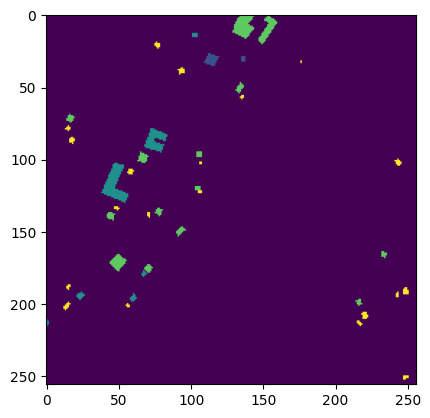

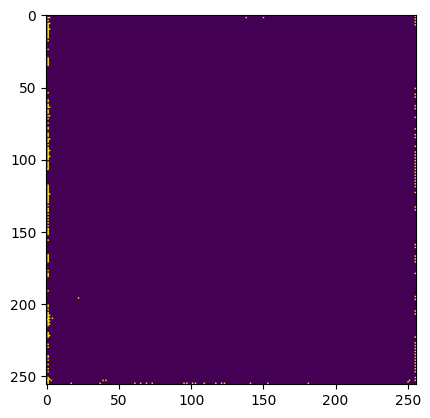

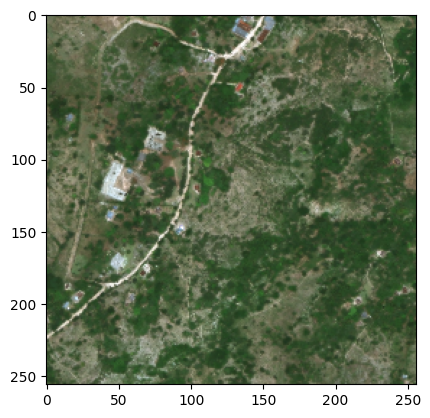

In [18]:
for X, Y in valid_test_dataset.take(1):
    print(f"Batch shape: {X.shape}, Mask shape: {Y.shape}")
    print(f"X dtype: {X.dtype}, Y dtype: {Y.dtype}")
    Y_pred = model.predict(X)
    plt.imshow(np.argmax(Y[1,:,:,:],axis=-1))
    plt.show()
    plt.imshow(np.argmax(Y_pred[1,:,:,:]*255,axis=-1))
    plt.show()
    plt.imshow(X[1,:,:,:3])
    plt.show()

In [17]:
# Load the model
model = unet_model() 
model.load_weights("../models/unet_v10_multiclass_epoch_03.h5")

# # Verify model architecture
# model.summary()

In [22]:
from sklearn.metrics import classification_report, jaccard_score


# Assume your dataset yields (image, mask) pairs
y_true_all = []
y_pred_all = []

for images, masks in test_dataset:  # tf.data.Dataset
    preds = model.predict(images)   # Shape: (batch_size, H, W, 1)
    
    # Binarize predictions (threshold at 0.5)
    y_true_flat = np.argmax(masks,axis=-1).flatten()
    y_pred = model.predict(images)
    y_pred_flat = np.argmax(y_pred, axis=-1).flatten()  # Convert to class labels

    # Flatten and collect all masks and predictions
    y_true_all.extend(y_true_flat)
    y_pred_all.extend(y_pred_flat)

# Convert to numpy arrays
y_true_all = np.array(y_true_all)
y_pred_all = np.array(y_pred_all)

# Generate classification report
report = classification_report(y_true_all, y_pred_all)

# Print to console (optional)
print(report)

# Save to file
with open("classification_report_unet_v11.txt", "w") as f:
    f.write(report)



2025-04-08 08:06:29.170240: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 244 of 5000
2025-04-08 08:06:39.162338: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 495 of 5000
2025-04-08 08:06:49.148683: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 769 of 5000
2025-04-08 08:06:55.522366: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


1/1 [==============================] - 5s 5s/step


: 

In [20]:
# Generate classification report
report = classification_report(y_true_all, y_pred_all)

# Print to console (optional)
print(report)

# Save to file
with open("classification_report.txt", "w") as f:
    f.write(report)

/home/taras/.pyenv/versions/3.10.12/envs/Artefact/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/taras/.pyenv/versions/3.10.12/envs/Artefact/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/taras/.pyenv/versions/3.10.12/envs/Artefact/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_pr

              precision    recall  f1-score   support

           0       0.94      1.00      0.97    488529
           1       0.00      0.00      0.00     34086
           2       0.00      0.00      0.00         0
           3       0.19      0.61      0.29      1494
           4       0.00      0.00      0.00       179

    accuracy                           0.93    524288
   macro avg       0.23      0.32      0.25    524288
weighted avg       0.87      0.93      0.90    524288



/home/taras/.pyenv/versions/3.10.12/envs/Artefact/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/taras/.pyenv/versions/3.10.12/envs/Artefact/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
# # Load the model data
# with open("models/unet_v8_multiclass_epoch_20.pkl", "rb") as f:
#     model_data = pickle.load(f)

# # Reconstruct the model
# model = model_from_json(model_data["architecture"])
# model.set_weights(model_data["weights"])

In [12]:
imno = 4

b1 = test_images[imno, :, :, :3]  # Take the first image
b2 = test_images[imno, :, :, 3:]  # Take the second image
a = model.predict(test_images[:, :, :, :])  # Predict on the first image
a = a[imno, :, :, :]  # Take the first channel (background)
c = test_masks[imno, :, :, :]  # Take the first mask (grayscale)


1/1 [==============================] - 3s 3s/step


2025-04-07 20:11:06.465670: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 279 of 500
2025-04-07 20:11:14.321418: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


1/1 [==============================] - 1s 693ms/step


(-0.5, 255.5, 255.5, -0.5)

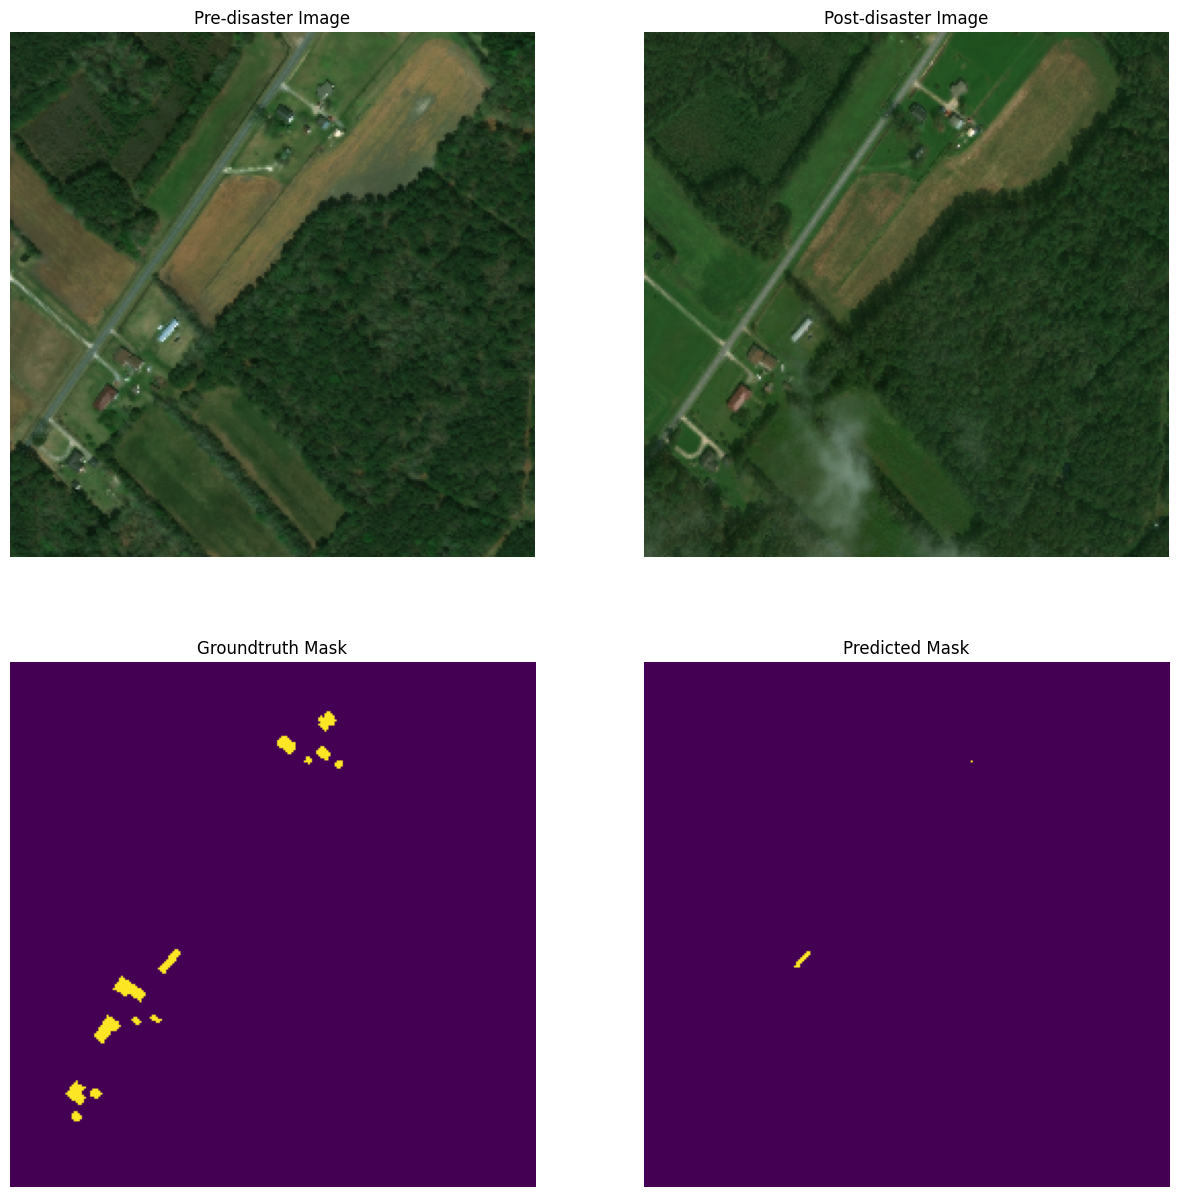

In [26]:
imno = 4
for images, masks in test_dataset.take(1):  # tf.data.Dataset
    image = images[imno, :, :, :]  # Take the first image
    mask = masks[imno, :, :, :]  # Take the first mask

pred = model.predict(images[:, :, :, :])  # Predict on the first image
pred = pred[imno, :, :, :]  

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.title("Pre-disaster Image")
plt.imshow(image[:,:,:3])
plt.axis('off')
plt.subplot(2, 2, 2)
plt.title("Post-disaster Image")
plt.imshow(image[:,:,3:])
plt.axis('off')
plt.subplot(2, 2, 3)
plt.title("Groundtruth Mask")
plt.imshow(np.argmax(mask, axis=-1))
plt.axis('off')
plt.subplot(2, 2, 4)
plt.title("Predicted Mask")
plt.imshow(np.argmax(pred, axis=-1))
plt.axis('off')

1/1 [==============================] - 1s 752ms/step


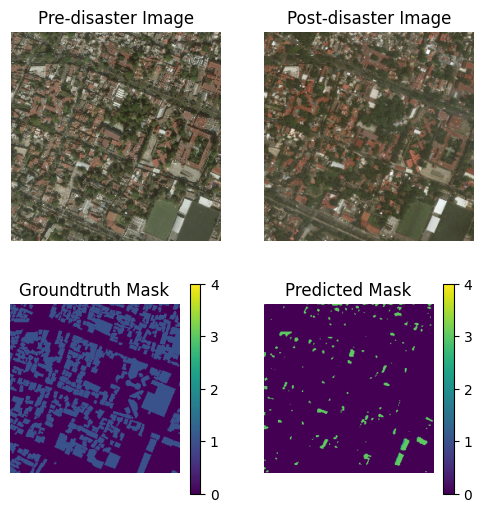

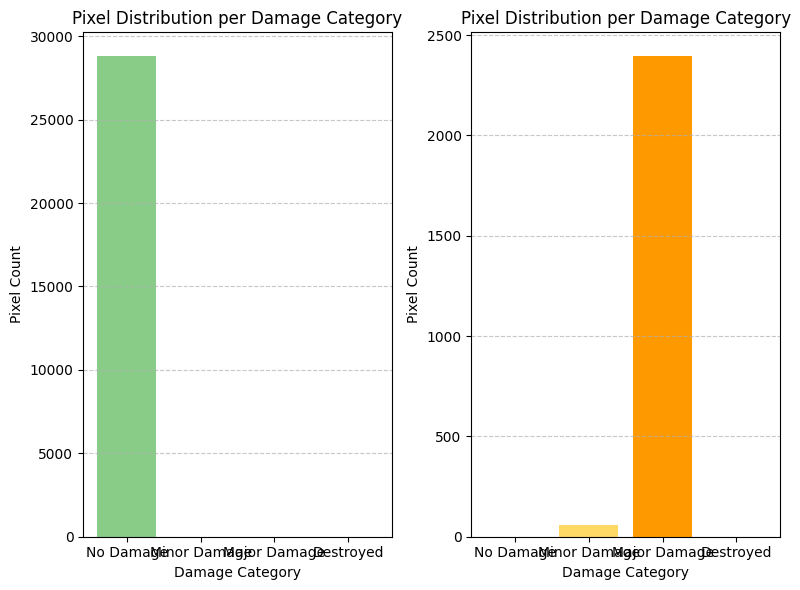

In [46]:
from collections import Counter

imno=7
image = images[imno, :, :, :]  # Take the first image
mask = masks[imno, :, :, :]  # Take the first mask

pred = model.predict(images[:, :, :, :])  # Predict on the first image
pred = pred[imno, :, :, :]  

plt.figure(figsize=(6,6))
plt.subplot(2, 2, 1)
plt.title("Pre-disaster Image")
plt.imshow(image[:,:,:3])
plt.axis('off')
plt.subplot(2, 2, 2)
plt.title("Post-disaster Image")
plt.imshow(image[:,:,3:])
plt.axis('off')
plt.subplot(2, 2, 3)
plt.title("Groundtruth Mask")
plt.imshow(np.argmax(mask, axis=-1),vmin=0, vmax=4)
plt.colorbar()
plt.axis('off')
plt.subplot(2, 2, 4)
plt.title("Predicted Mask")
plt.imshow(np.argmax(pred, axis=-1),vmin=0, vmax=4)
plt.axis('off')
plt.colorbar()


# Count occurrences of each class using Counter
class_counts = Counter(np.argmax(mask, axis=-1).flatten())

# Ensure all classes 1–4 are in the count (even if 0)
damage_categories = [1, 2, 3, 4]
counts = [class_counts.get(cat, 0) for cat in damage_categories]

# Labels for each class
labels = ['No Damage', 'Minor Damage', 'Major Damage', 'Destroyed']

# Plot bar chart
plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
plt.bar(labels, counts, color=['#88cc88', '#ffd966', '#ff9900', '#cc0000'])
plt.title("Pixel Distribution per Damage Category")
plt.ylabel("Pixel Count")
plt.xlabel("Damage Category")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Count occurrences of each class using Counter
class_counts = Counter(np.argmax(pred, axis=-1).flatten())

# Ensure all classes 1–4 are in the count (even if 0)
damage_categories = [1, 2, 3, 4]
counts = [class_counts.get(cat, 0) for cat in damage_categories]

plt.subplot(1, 2, 2)
plt.bar(labels, counts, color=['#88cc88', '#ffd966', '#ff9900', '#cc0000'])
plt.title("Pixel Distribution per Damage Category")
plt.ylabel("Pixel Count")
plt.xlabel("Damage Category")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

Number of 1s per channel: [966357.  48884.  12854.   2232.  18249.]
1/1 [==============================] - 2s 2s/step
Number of 1s per channel: [944105.06   80561.19    8816.484  11725.061   5055.494]


[]

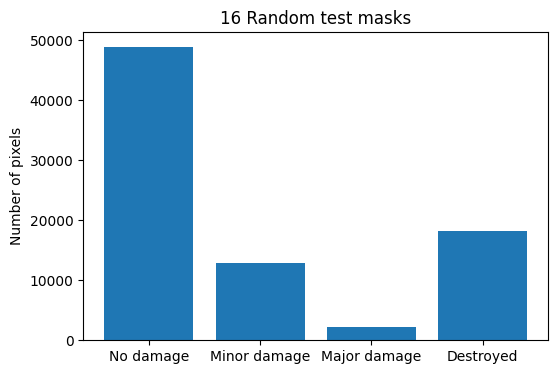

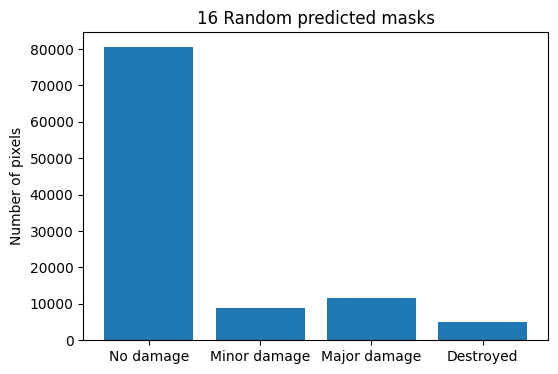

In [13]:
counts_per_channel = np.sum(test_masks, axis=(0, 1, 2))  # Sum over all images and pixels
print("Number of 1s per channel:", counts_per_channel)
plt.figure(figsize=(6,4))
plt.bar([1,2,3,4],counts_per_channel[1:])  # For values 0–4
plt.xticks([1,2,3,4], ["No damage", "Minor damage", "Major damage", "Destroyed"])
plt.ylabel("Number of pixels")
plt.title("16 Random test masks")
plt.plot()

counts_per_channel = np.sum(model.predict(test_images), axis=(0, 1, 2))  # Sum over all images and pixels
print("Number of 1s per channel:", counts_per_channel)
plt.figure(figsize=(6,4))
plt.bar([1,2,3,4],counts_per_channel[1:])  # For values 0–4
plt.xticks([1,2,3,4], ["No damage", "Minor damage", "Major damage", "Destroyed"])
plt.ylabel("Number of pixels")
plt.title("16 Random predicted masks")
plt.plot()


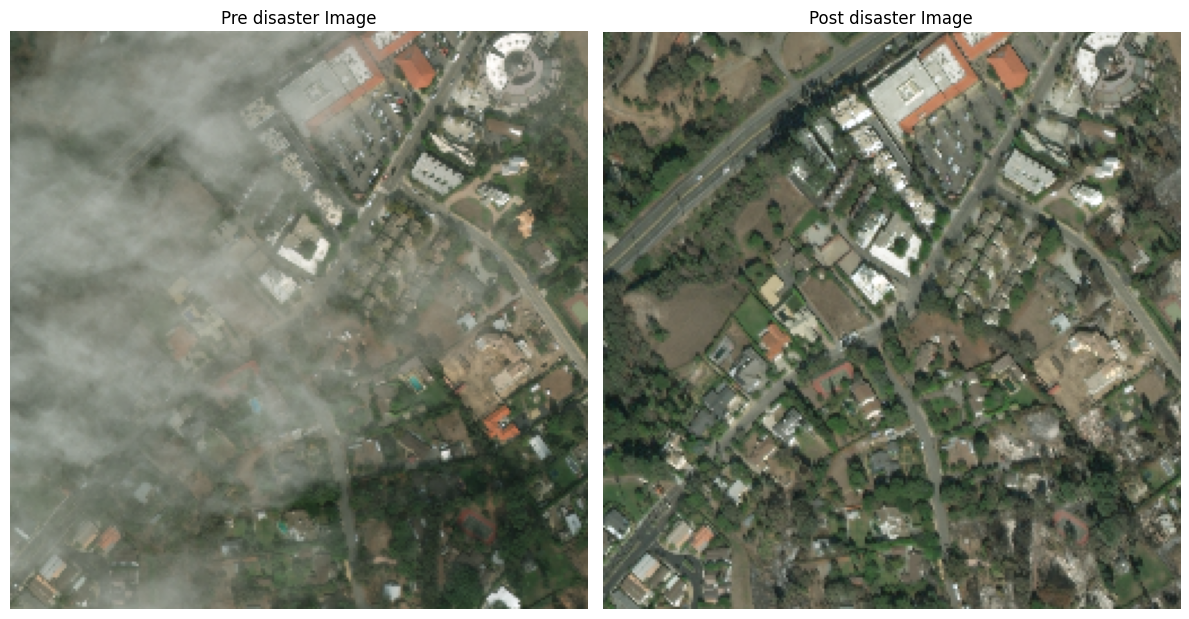

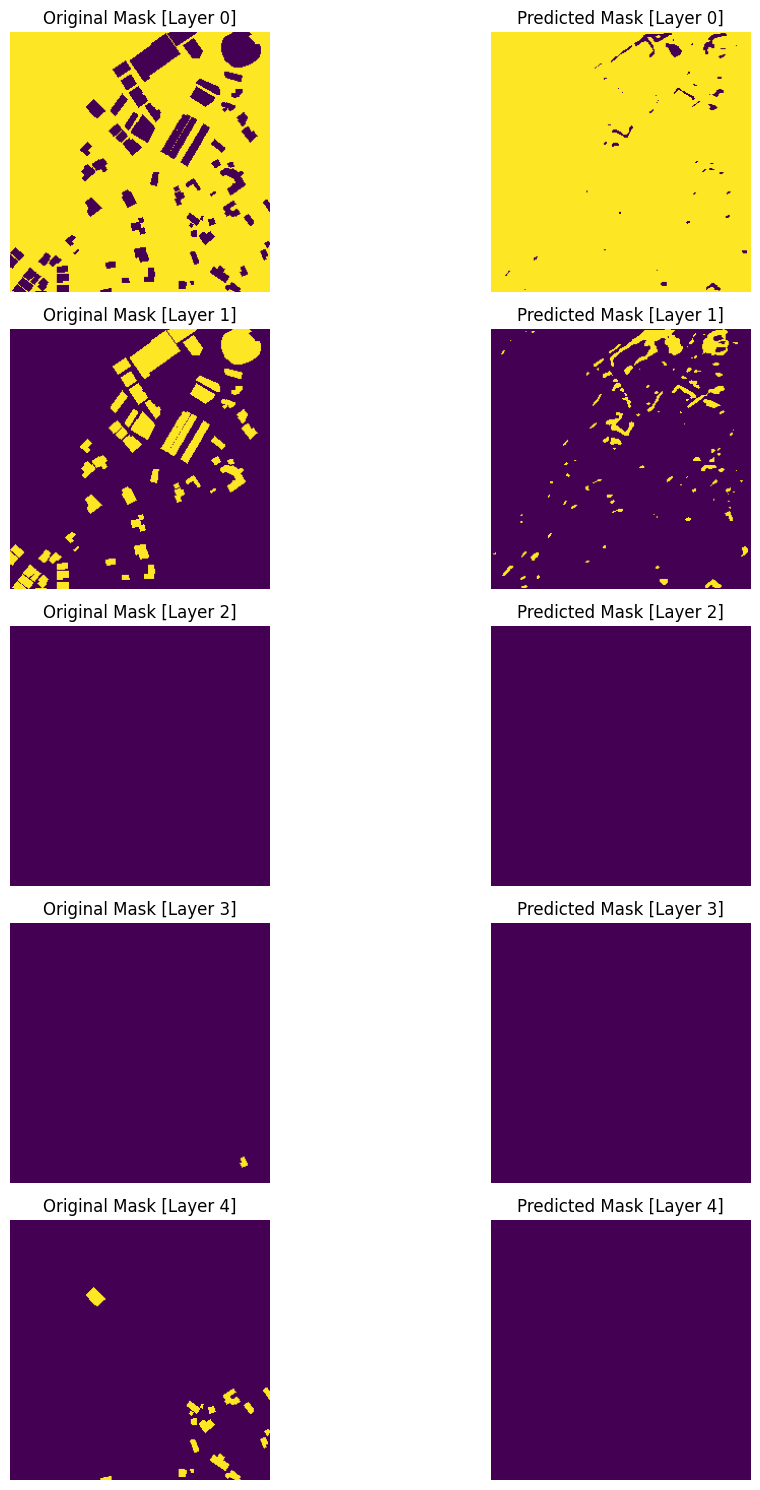

In [17]:

plt.figure(figsize=(12, 15))  # Width x Height in inches

plt.subplot(121)
plt.title("Pre disaster Image")
plt.imshow(b1)  # Take the first image)
plt.axis('off')

plt.subplot(122)
plt.title("Post disaster Image")
plt.imshow(b2)  # Take the first image)
plt.axis('off')
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


plt.figure(figsize=(12, 15))

# Original vs Predicted per channel
for i in range(5):
    plt.subplot(5, 2, 2*i + 1)
    plt.title(f"Original Mask [Layer {i}]")
    plt.imshow(c[:, :, i])
    plt.axis('off')

    plt.subplot(5, 2, 2*i + 2)
    plt.title(f"Predicted Mask [Layer {i}]")
    plt.imshow(a[:, :, i]>0.4, vmin=0, vmax=1)
    plt.axis('off')

plt.tight_layout()
plt.show()

(256, 256, 5)
(256, 256, 3)


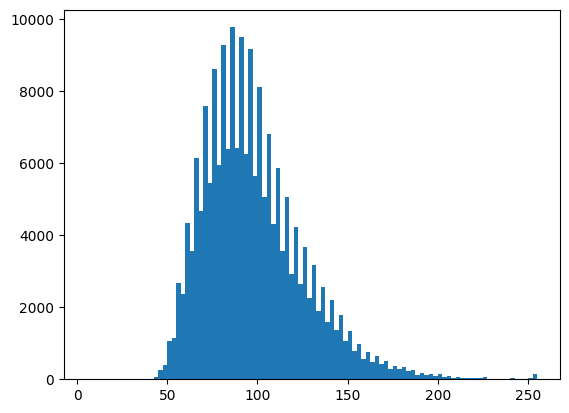

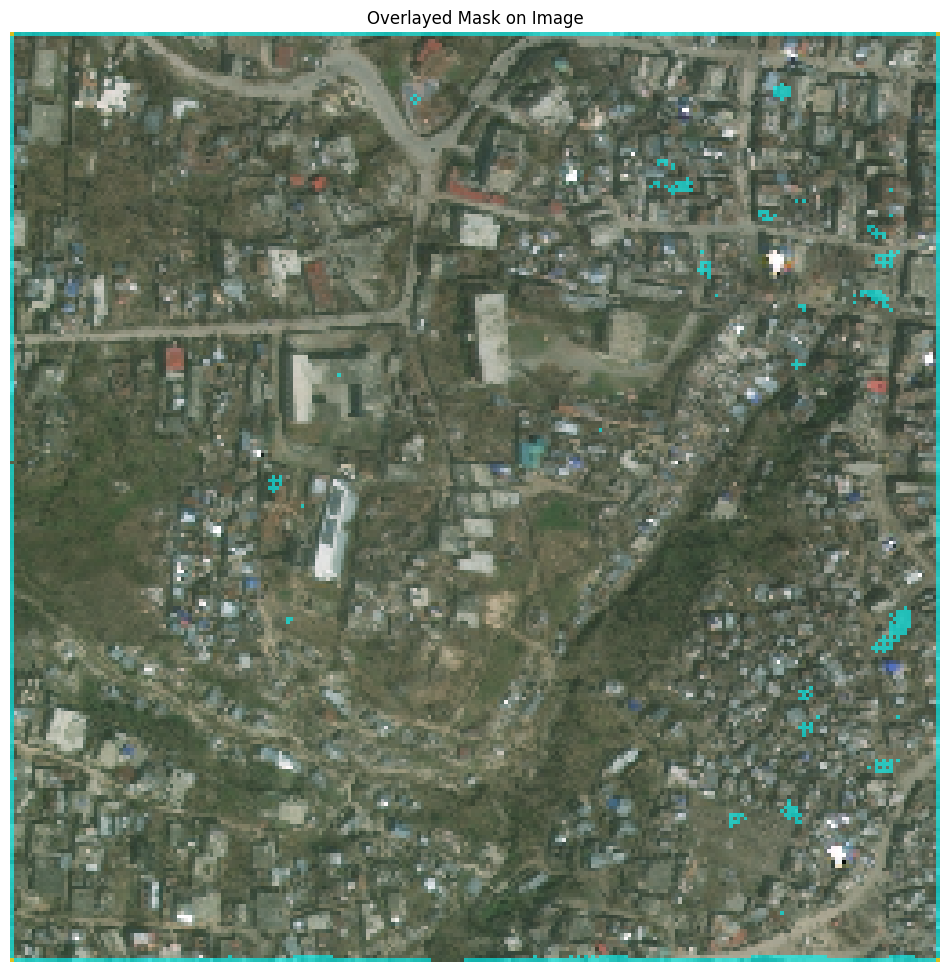

In [130]:
import numpy as np
import cv2

def overlay_masks_on_image(image, mask, alpha=0.4):
    """
    Overlays a color image with a 5-channel mask.
    
    Parameters:
        image (np.ndarray): RGB image of shape (X, Y, 3), dtype=uint8.
        mask (np.ndarray): One-hot encoded mask of shape (X, Y, 5), dtype=uint8 or bool.
        alpha (float): Transparency of the mask overlay.
        
    Returns:
        np.ndarray: Image of shape (X, Y, 3) with mask overlay.
    """
    # Define RGBA colors for each layer (skip layer 0: transparent)

    colors = {
        1: (0, 255, 255),    # Cyan
        2: (255, 255, 0),    # Yellow
        3: (255, 165, 0),    # Orange
        4: (255, 0, 0),      # Red
    }

    overlay = image.copy()

    for i in range(1, 5):  # Skip channel 0 (transparent)
        mask_layer = mask[:, :, i]
        color = np.array(colors[i], dtype=np.uint8)

        # Create a colored layer with the mask
        color_mask = np.zeros_like(image, dtype=np.uint8)
        for c in range(3):
            color_mask[:, :, c] = color[c] * mask_layer

        # Blend the color mask with the original image
        overlay = np.where(mask_layer[..., None], 
                           (1 - alpha) * overlay + alpha * color_mask,
                           overlay)

    return overlay.astype(np.uint8)

image = np.array(b2)*255
mask = np.array(a>0.1)
print(mask.shape)


plt.hist(image.flatten(), bins=100)

result = overlay_masks_on_image(image, mask, alpha=0.6)  # Overlay the mask on the image
print(result.shape)
plt.figure(figsize=(12, 15))
plt.imshow(result[:,:,:])
plt.axis('off')
plt.title("Overlayed Mask on Image")
plt.show()

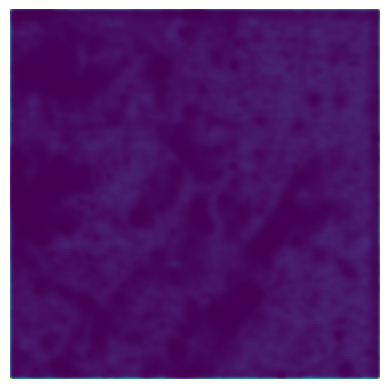

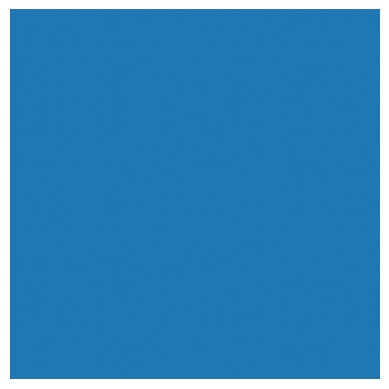

(256, 256, 5)
(256, 256)


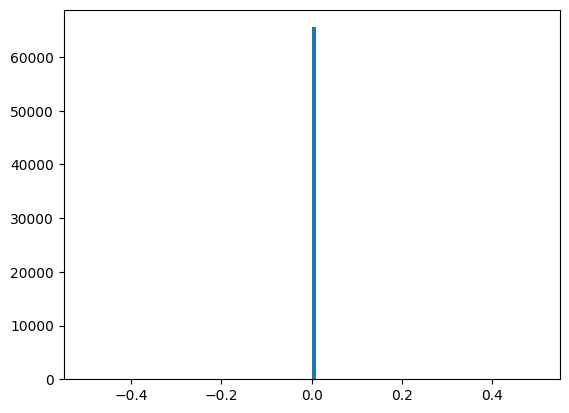

In [144]:
a.shape
plt.imshow(a[:,:,4])
plt.axis('off')
plt.show()
aa = tf.argmax(a, axis=-1)  # Ground truth labels

plt.imshow(aa, cmap='tab10')
plt.axis('off')
plt.show()
print(a.shape)
print(aa.shape)
plt.hist(np.array(aa).flatten(), bins=100)
plt.show(   )